# **TGS SALT IDENTIFICATION CHALLENGE**

# **Segment salt deposits beneath the Earth's surface**

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

The task is to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

In [0]:
from matplotlib import image
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import os

import numpy as np
from tqdm import tqdm_notebook, tnrange
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import sys
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# **Loading and Resizing training images**

In [0]:

path = "tgs_data/train"
PATH_TRAIN ="tgs_data/train/images"
PATH_TEST = "tgs_data/test/images"
train_ids = os.listdir(PATH_TRAIN)
test_ids = os.listdir(PATH_TEST)

print (len(train_ids))

im_width = 128
im_height = 128
im_chan = 1

X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = "tgs_data/train"
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Finished resizing!')



4000
Getting and resizing train images and masks ... 



Done!


# **Displaying a resized-training image**

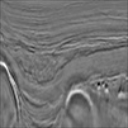

In [0]:
a = array_to_img(X_train[10])
a


# **Mean_IOU**
An evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# **U-NET Model**
The implementation of U-Net model. It is regarded as one of the best architectures for image segmentation.
 
Link to original paper: https://arxiv.org/pdf/1505.04597.pdf

In [0]:
from keras.optimizers import Adam
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 128, 128, 1)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 128, 128, 8)  80          lambda_8[0][0]                   
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 128, 128, 8)  584         conv2d_110[0][0]                 
____________________________________________________________________________________________

# **Training over the data and plotting loss and accuracy graphs**

In [0]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.25, epochs=50, 
                    callbacks=[earlystopper, checkpointer])
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model accuracy')
plt.ylabel('mean IOU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('tgs_data.h5')